In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras
from keras import regularizers
import os 
import tempfile
from keras import applications

In [14]:
#%%
# re-size all the images to this
IMAGE_SIZE = [224, 224]

#%%

callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model_InceptionV31.h5', monitor='val_loss', save_best_only=True)]

#%%
# add preprocessing layer to the front of VGG
base_model = tf.keras.applications.DenseNet201(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

#%%

In [15]:
'''regularizer = tf.keras.regularizers.l2(l=0.5)

for layer in base_model.layers:
    for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
          setattr(layer, attr, regularizer)'''
          
def add_regularization(model, regularizer=tf.keras.regularizers.l2(0.75)):

    if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
      print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
      return model

    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
              setattr(layer, attr, regularizer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)

    # load the model from the config
    model = tf.keras.models.model_from_json(model_json)
    
    # Reload the model weights
    model.load_weights(tmp_weights_path, by_name=True)
    return model
          
#%%
  
add_regularization(base_model)

#%%
    

In [16]:


# don't train existing weights
for layer in base_model.layers:
  layer.trainable = False
  
base_model.summary()
 
#%% 

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

#%%
# our layers - you can add more if you want
prediction_layer = tf.keras.layers.Dense(3, activation='softmax')

#%%
# create a model object
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

# view the structure of the model
model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [17]:
#%%
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer=optimizers.Adam(lr=0.01),
  metrics=['accuracy']
)


#%%
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

#%%

test_datagen = ImageDataGenerator(rescale = 1./255)


In [18]:
'''import os
import shutil
directory = '/content/drive/MyDrive/hippodeep_pytorch-master/NC/2d_NC'
s=os.listdir(directory)
print(s)
for filename in s:
    if filename.endswith(".png"):
      print(filename)
      shutil.copyfile('/content/drive/MyDrive/hippodeep_pytorch-master/NC/2d_NC/'+filename,'/content/drive/MyDrive/Transfer Learning Codes/Transfer/Train/NC/'+filename)
      #os.remove('/content/drive/MyDrive/hippodeep_pytorch-master/NC/NC/'+filename)
      continue
    else:
      continue'''

'import os\nimport shutil\ndirectory = \'/content/drive/MyDrive/hippodeep_pytorch-master/NC/2d_NC\'\ns=os.listdir(directory)\nprint(s)\nfor filename in s:\n    if filename.endswith(".png"):\n      print(filename)\n      shutil.copyfile(\'/content/drive/MyDrive/hippodeep_pytorch-master/NC/2d_NC/\'+filename,\'/content/drive/MyDrive/Transfer Learning Codes/Transfer/Train/NC/\'+filename)\n      #os.remove(\'/content/drive/MyDrive/hippodeep_pytorch-master/NC/NC/\'+filename)\n      continue\n    else:\n      continue'

In [19]:

#%%

training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Transfer Learning Codes/Transfer/Train',
                                                 target_size = IMAGE_SIZE,
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

#%%

test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Transfer Learning Codes/Transfer/Test',
                                            target_size = IMAGE_SIZE,
                                            batch_size = 32,
                                            class_mode = 'categorical')

#%%

validation_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Transfer Learning Codes/Transfer/Validation',
                                            target_size = IMAGE_SIZE,
                                            batch_size = 32,
                                            class_mode = 'categorical')

#%%


Found 553 images belonging to 3 classes.
Found 15 images belonging to 3 classes.
Found 62 images belonging to 3 classes.


In [20]:
initial_epochs = 150

#%%
# fit the model
history = model.fit_generator(
  training_set,
  validation_data=validation_set,
  epochs=initial_epochs,
  steps_per_epoch=len(training_set),
  validation_steps=len(validation_set),
  callbacks=callbacks
)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
18/18 [==============================] - 18s 530ms/step - loss: 2.8229 - accuracy: 0.4403 - val_loss: 1.3758 - val_accuracy: 0.6290
Epoch 2/150
18/18 [==============================] - 7s 380ms/step - loss: 1.1574 - accuracy: 0.5650 - val_loss: 1.4374 - val_accuracy: 0.3871
Epoch 3/150
18/18 [==============================] - 7s 381ms/step - loss: 1.0057 - accuracy: 0.5385 - val_loss: 1.1502 - val_accuracy: 0.5968
Epoch 4/150
18/18 [==============================] - 7s 387ms/step - loss: 0.8246 - accuracy: 0.6317 - val_loss: 1.7919 - val_accuracy: 0.3871
Epoch 5/150
18/18 [==============================] - 7s 377ms/step - loss: 0.8055 - accuracy: 0.6520 - val_loss: 0.9906 - val_accuracy: 0.5645
Epoch 6/150
18/18 [==============================] - 7s 380ms/step - loss: 0.7030 - accuracy: 0.6940 - val_loss: 1.0539 - val_accuracy: 0.5645
Epoch 7/150
18/18 [==============================] - 7s 383ms/step - loss: 0.7338 - accuracy: 0.6641 - val_loss: 1.4143 - val_accuracy: 0.435

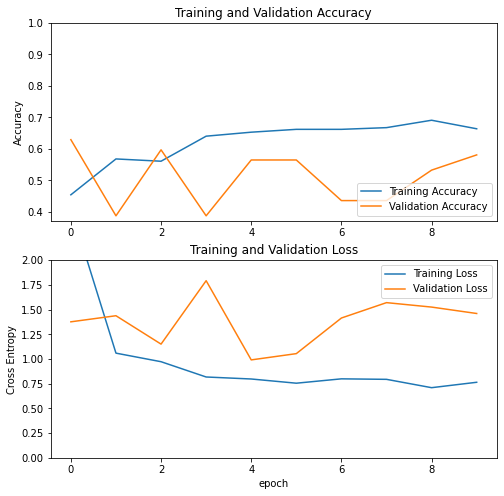

Number of layers in the base model:  707
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 5763      
Total params: 18,327,747
Trainable params: 2,648,003
Non-trainable params: 15,679,744
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 10/59
18/18 [==============================] - 19s 536ms/step - loss: 1.9793 - accuracy: 0.5841 - val_loss: 89.2286 - val_accuracy: 0.1613
Epoch 11/59
18/18 [==============================] - 7s 391ms/step - loss: 0.7589 - accuracy: 0.6812 - val_loss: 21.9098 - val_accuracy: 0.1613
Epoch 12/59
18/18 [==============================] - 7s 398ms/step - loss: 0.8699 - accuracy: 0.6506 - val_loss: 2.4721 - val_accuracy: 0.3387
Epoch 13/59
18/18 [==============================] - 7s 381ms/step - loss: 1.0046 - accuracy: 0.6426 - val_loss: 4.6934 - val_accuracy: 0.3387
Epoch 14/59
18/18 [==============================] - 7s 386ms/step - loss: 1.0253 - accuracy: 0.6388 - val_loss: 3.3053 - val_accuracy: 0.3871
Epoch 15/59
18/18 [==============================] - 7s 385ms/step - loss: 0.8475 - accuracy: 0.6739 - val_loss: 2.9171 - val_accuracy: 0.4677
Epoch 16/59
18/18 [==============================] - 7s 385ms/step - loss: 0.5769 - accuracy: 0.7648 - val_loss: 3.9857 - val_accuracy: 0.3

In [ ]:



#%%
'''r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)'''

#%%

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#%%

base_model.trainable = True

#%%

print("Number of layers in the base model: ", len(base_model.layers))

#%%

fine_tune_at = 635

#%%

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False
  
#%%
  
model.compile(
  loss='categorical_crossentropy',
  optimizer=optimizers.Adam(lr=0.01),
  metrics=['accuracy']
)  

#%%

model.summary()

#%%

len(model.trainable_variables)

#%%
initial_epochs=9
fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

#%%
history_fine = model.fit_generator(
  training_set,
  validation_data=validation_set,
  epochs=total_epochs,
  initial_epoch=history.epoch[-1],
  steps_per_epoch=len(training_set),
  validation_steps=len(validation_set),
  callbacks=callbacks
)


#%%

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#%%

'''acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()'''